In [1]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


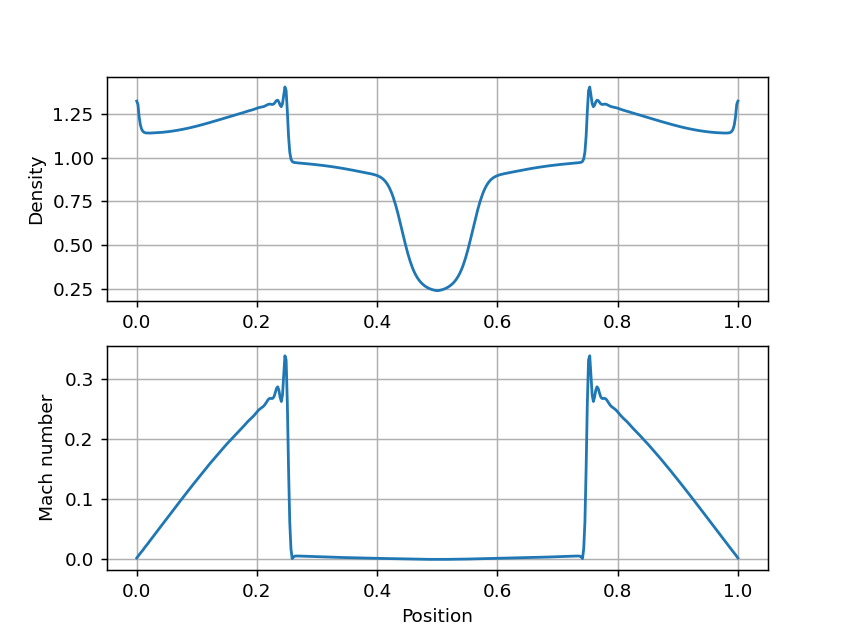

In [3]:
Nsteps = 1000
Q = 1e-2
A = 10 # Perturbation amplitude
d = 0.01 # Perturbation width
N = 500 # Leftmost cell is 0, rightmost cell is N
X = np.linspace(0, 1, N)
dx = X[1] - X[0]
dt = 5e-4

gaussian = A*np.exp(-(X-0.5)**2/ (2*d**2))
density = np.ones(X.shape)
momentum = np.zeros(X.shape)
energy = np.ones(X.shape)
energy += gaussian

%matplotlib notebook
fig, axs = plt.subplots(2)
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(Nsteps):
    # 1) Advection velocity & flux at cell interfaces
    velocity_interface = 1/2 * (momentum[:-1]/density[:-1] + momentum[1:]/density[1:])
    velocity_interface = [0] + list(velocity_interface) + [0]
    flux_dens = []
    flux_mom = []

    for i, veloc in enumerate(velocity_interface):
        if veloc == 0:
            flux_dens.append(0)
            flux_mom.append(0)
        elif veloc < 0:
            flux_dens.append(veloc * density[i])
            flux_mom.append(veloc * momentum[i])
        else:
            flux_dens.append(veloc * density[i-1])
            flux_mom.append(veloc * momentum[i-1])
    flux_dens = np.array(flux_dens)
    flux_mom = np.array(flux_mom)

    # 2) Update density and momentum without source
    density -= dt/dx * (flux_dens[1:] - flux_dens[:-1])
    momentum -= dt/dx * (flux_mom[1:] - flux_mom[:-1])

    # 3) Add pressure gradient as source to update momentum
    u = momentum/density # velocity at center of cell
    pressure = (energy - density/2 * u**2)*(5/3-1)    
    momentum[1:-1] -= dt/dx/2 * (pressure[2:] - pressure[:-2])

    # 4) Pressure gradient at boundary
    momentum[0] -= dt/dx/2 * (pressure[1] - pressure[0])
    momentum[-1] -= dt/dx/2 * (pressure[-1] - pressure[-2])

    # 5) Advection velocity & energy flux
    velocity_interface = 1/2 * (momentum[:-1]/density[:-1] + momentum[1:]/density[1:])
    velocity_interface = [0] + list(velocity_interface) + [0]
    flux_en = []
    for i, veloc in enumerate(velocity_interface):
        if veloc == 0:
            flux_en.append(0)
        elif veloc < 0:
            flux_en.append(veloc * energy[i])
        else:
            flux_en.append(veloc * energy[i-1])
    flux_en = np.array(flux_en)

    # 6) Update energy without source
    energy -= dt/dx * (flux_en[1:] - flux_en[:-1])

    # 7) Add pressure gradient as source to update energy
    u = momentum/density
    pressure = (energy - density/2 * u**2)*(5/3-1)
    energy[1:-1] -= dt/dx/2 * (u[2:]*pressure[2:] - u[:-2]*pressure[:-2])

    # 8) Pressure gradient at boundary
    energy[0] -= dt/dx/2 * (u[1]*pressure[1] - u[0]*pressure[0])
    energy[-1] -= dt/dx/2 * (u[-1]*pressure[-1] - u[-2]*pressure[-2])

    # 9) Upddate pressure and sound speed
    pressure = (energy - density/2 * u**2)*(5/3-1)
    Cs = np.sqrt(5/3*pressure/density)
    mach = u/Cs

    # Plotting
    axs[0].clear()
    axs[1].clear()
    #     axs[0].set_ylim(1, 1+2*A)
    axs[0].plot(X, density)
    axs[1].plot(X, np.abs(mach))
    axs[0].set_ylabel('Density')
    axs[1].set_ylabel('Mach number')
    axs[1].set_xlabel('Position')
    axs[0].grid()
    axs[1].grid()
    fig.canvas.draw()
    plt.pause(0.001)